<a href="https://colab.research.google.com/github/leomaurodesenv/kaggle/blob/main/jupyter/company_challenge-desafio_de_inteligencia_artificial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge
**Código**: leomaurodesenv <leo.mauro.desenv@gmail.com> ( [Github](https://github.com/leomaurodesenv/kaggle) )

A \< empresa \> tem o objetivo de desburocratizar os serviços cartorários para nossos clientes B2B, realizando a busca, gestão e pré-análise dos documentos, assim reduzindo o tempo de entrega e acompanhando o andamento de seu pedido através do nosso produto.

## Desafio

Atualmente, nossos clientes solicitam ou nos enviam vários tipos de documentos. A partir desses documentos, extraímos e selecionamos diversas informações importantes para eles. Para que essas informações sejam corretamente extraídas, um processo automático de classificação do tipo de documento é necessário.

O desafio é a classificação de pelo menos os documentos RG e CPF, usando suas imagens, através de aprendizagem de máquina (machine learning).

---
# Coleta e Produção do Dataset

Utilizaremos as imagens de RG, CNH e CPF do conjunto de dados [ricardobnjunior/Brazilian-Identity-Document-Dataset](https://github.com/ricardobnjunior/Brazilian-Identity-Document-Dataset), chamado de BID Dataset. Para simplificar os processos no Google Colab, utilizaremos apenas uma amostragem do dataset (~ 70MB) e não o conjunto completo (~ 8GB).

In [1]:
%%capture
!pip install gdown

In [2]:
# full dataset
# !gdown 1Oi88TRcpdjZmJ79WDLb9qFlBNG8q2De6

In [3]:
# sample dataset
!gdown 144EqqmMtCziua9iYo-3afUEvZrJVxUXU

Downloading...
From: https://drive.google.com/uc?id=144EqqmMtCziua9iYo-3afUEvZrJVxUXU
To: /content/BID Sample Dataset.zip
100% 71.1M/71.1M [00:00<00:00, 137MB/s]


In [4]:
%%capture
# abrindo o dataset
PATH = "/content/BID Sample Dataset"
!unzip "{PATH}.zip"

## Limpando o Dataset

Repare que o dataset contem diversos tipos de images: CNH aberta, CNH frente, CNH verso e etc. Selecionaremos os seguintes tipos de imagens para este case: `CNH_Frente`, `CPF_Frente` e `RG_Frente`.

In [5]:
# removendo classes desnecessárias
!rm -r "{PATH}/CNH_Aberta"
!rm -r "{PATH}/CNH_Verso"
!rm -r "{PATH}/CPF_Verso"
!rm -r "{PATH}/RG_Aberto"
!rm -r "{PATH}/RG_Verso"

In [6]:
# removendo arquivos desnecessários
!find "{PATH}/CNH_Frente/" -maxdepth 1 -type f -name "*_ocr.txt" -delete
!find "{PATH}/CNH_Frente/" -maxdepth 1 -type f -name "*_segmentation.jpg" -delete
!ls "{PATH}/CNH_Frente/"

00003604_in.jpg  00003613_in.jpg  00003622_in.jpg  00003631_in.jpg
00003605_in.jpg  00003614_in.jpg  00003623_in.jpg  00003632_in.jpg
00003606_in.jpg  00003615_in.jpg  00003624_in.jpg  00003633_in.jpg
00003607_in.jpg  00003616_in.jpg  00003625_in.jpg  00003634_in.jpg
00003608_in.jpg  00003617_in.jpg  00003626_in.jpg  00003635_in.jpg
00003609_in.jpg  00003618_in.jpg  00003627_in.jpg  00003636_in.jpg
00003610_in.jpg  00003619_in.jpg  00003628_in.jpg  00003637_in.jpg
00003611_in.jpg  00003620_in.jpg  00003629_in.jpg  00003638_in.jpg
00003612_in.jpg  00003621_in.jpg  00003630_in.jpg  00003639_in.jpg


In [7]:
# removendo arquivos desnecessários
!find "{PATH}/CPF_Frente/" -maxdepth 1 -type f -name "*_ocr.txt" -delete
!find "{PATH}/CPF_Frente/" -maxdepth 1 -type f -name "*_segmentation.jpg" -delete
!find "{PATH}/RG_Frente/" -maxdepth 1 -type f -name "*_ocr.txt" -delete
!find "{PATH}/RG_Frente/" -maxdepth 1 -type f -name "*_segmentation.jpg" -delete

Vejamos um exemplo de imagem

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


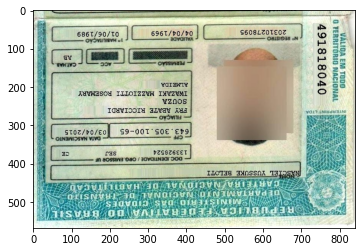

In [9]:
%pylab inline
img = mpimg.imread(f'{PATH}/CNH_Frente/00003607_in.jpg')
imgplot = plt.imshow(img)
plt.show()

## Construindo o Dataset

Vamos construir o conjunto de treinamento e teste (validação) utilizando o `Keras`.

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [11]:
import pathlib
data_dir = pathlib.Path(PATH)
data_dir

PosixPath('/content/BID Sample Dataset')

In [12]:
# definições do conjunto de dados
seed = 123
crop = False
batch_size = 32
img_height = 400
img_width = 400
validation_split = 0.2

# conjunto de treinamento
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir, validation_split=validation_split, subset="training", seed=seed,
  image_size=(img_height, img_width), batch_size=batch_size, crop_to_aspect_ratio=crop,
)

# conjunto de validação
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir, validation_split=validation_split, subset="validation", seed=seed,
  image_size=(img_height, img_width), batch_size=batch_size, crop_to_aspect_ratio=crop,
)

Found 108 files belonging to 3 classes.
Using 87 files for training.
Found 108 files belonging to 3 classes.
Using 21 files for validation.


In [13]:
# nome das classes
class_names = train_ds.class_names
class_names

['CNH_Frente', 'CPF_Frente', 'RG_Frente']

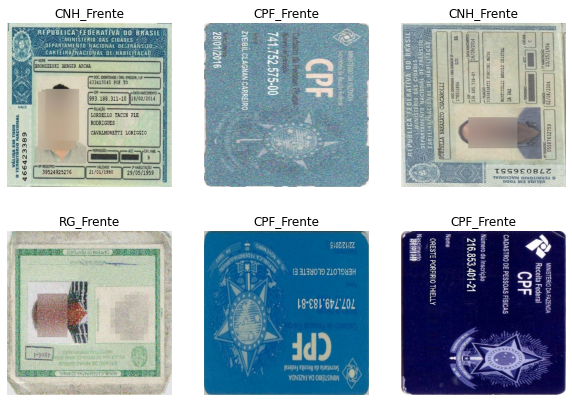

In [14]:
# visualizando o conjunto de treino
plt.figure(figsize=(10, 7))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

---
# Machine Learning

Nesta seção vamos configurar as etapas de preprocessamento e o modelo de classificação de imagens. O preprocessamento consiste na Augmentação e Padronização das Imagens. Enquanto, o modelo será uma Rede Neural Convolucional + Feed Forward com Dropout.

In [15]:
# configurando buffer para carregamento mais rápido das imagens
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(seed).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

Para evitar overfitting, pois temos um conjunto de dados pequeno, e para aumentar a quantidade de dados do dataset; vamos conduzir uma Augmentação sobre os dados. Utilizaremos três tipos de augmentação, são eles: rotação de imagem, flipping e ajuste de zoom.

>  Observação: a agumentação de dados dados é desativada no momento do teste, portanto, as imagens de entrada só serão aumentadas durante as chamadas para `Model.fit` sobre o conjunto de treinamento. 

In [16]:
# normalização dos dados
# -- redimensionar as figuras para o tamanho adequado
# -- normalizar os valores entre [0, 1]
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(img_height, img_width),
  layers.Rescaling(1./255)
])

In [17]:
# augmentação de dados
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.05),
])

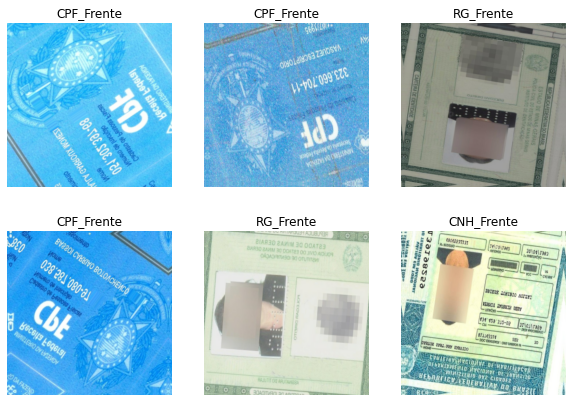

In [18]:
# visualizando os dados augmentados
plt.figure(figsize=(10, 7))
for images, labels in train_ds.take(1):
  for i in range(6):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Construção do Modelo

Nossa Rede Neural é composta pelas camadas (i) de preprocessamento (normalização e augmentação de dados); (ii) camadas convolucionais; e (iii) Feed Forward para a classificação do modelo. Adicionemos uma camada de Dropout no final da camada convolucional para evitar overfitting na rede de classificação.

> Observação: dado que este modelo apresenta camadas de data augmentation e dropout, é esperado que sua convergência seja mais lenta (ou seja, sejam necessárias mais épocas de treinamento). Contudo, este modelo será mais adaptativo a dados reais e evitará o overfitting.

In [19]:
num_classes = len(class_names)

model = Sequential([
  # preprocessamento
  data_augmentation,
  resize_and_rescale,
  # convolutional layers
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # feed foward layers
  layers.Flatten(),
  layers.Dropout(0.1),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [20]:
%%time
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
3/3 [==============================] - 19s 6s/step - loss: 7.0933 - accuracy: 0.3678 - val_loss: 1.9496 - val_accuracy: 0.4286
Epoch 2/10
3/3 [==============================] - 16s 5s/step - loss: 1.3138 - accuracy: 0.4368 - val_loss: 0.6809 - val_accuracy: 0.7619
Epoch 3/10
3/3 [==============================] - 16s 5s/step - loss: 0.7643 - accuracy: 0.6667 - val_loss: 0.7622 - val_accuracy: 0.4762
Epoch 4/10
3/3 [==============================] - 16s 6s/step - loss: 0.5539 - accuracy: 0.7011 - val_loss: 0.5406 - val_accuracy: 0.4762
Epoch 5/10
3/3 [==============================] - 18s 5s/step - loss: 0.4532 - accuracy: 0.7931 - val_loss: 0.4427 - val_accuracy: 0.6667
Epoch 6/10
3/3 [==============================] - 18s 6s/step - loss: 0.4083 - accuracy: 0.7701 - val_loss: 0.2534 - val_accuracy: 0.9524
Epoch 7/10
3/3 [==============================] - 17s 6s/step - loss: 0.2836 - accuracy: 0.8621 - val_loss: 0.4483 - val_accuracy: 0.7619
Epoch 8/10
3/3 [==================

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 400, 400, 3)       0         
                                                                 
 sequential (Sequential)     (None, 400, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 400, 400, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 200, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                  

### Salvando o Modelo

In [22]:
PATH_MODEL = '/content/model_checkpoint'
model.save(
    PATH_MODEL,
    overwrite=True, include_optimizer=True, save_traces=True
)

In [23]:
# tamanho do modelo
!du -h "{PATH_MODEL}"
!zip -r model.zip "{PATH_MODEL}"

235M	/content/model_checkpoint/variables
4.0K	/content/model_checkpoint/assets
236M	/content/model_checkpoint
  adding: content/model_checkpoint/ (stored 0%)
  adding: content/model_checkpoint/variables/ (stored 0%)
  adding: content/model_checkpoint/variables/variables.data-00000-of-00001 (deflated 24%)
  adding: content/model_checkpoint/variables/variables.index (deflated 67%)
  adding: content/model_checkpoint/assets/ (stored 0%)
  adding: content/model_checkpoint/keras_metadata.pb (deflated 93%)
  adding: content/model_checkpoint/saved_model.pb (deflated 89%)


### Carregando o Modelo

In [24]:
from tensorflow.keras.models import load_model

model2 = load_model('/content/model_checkpoint')
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 400, 400, 3)       0         
                                                                 
 sequential (Sequential)     (None, 400, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 400, 400, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 200, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                  

## Desempenho do Modelo

Conseguimos construir um modelo com alta acurácia e com baixo viés de overfitting.

> Observação: reparamos que a acurácia do treinamento é conturbada. Isto ocorre devido as camadas de data augmentation e dropout. Contudo, conseguimos ver uma melhora crescente na avaliação do conjunto de validação.

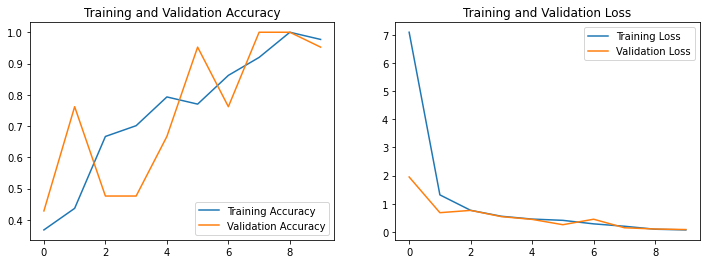

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()